In [4]:
import joblib
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import umap

RANDOM_STATE = 42  # if your class references it

# 1) Define or (preferably) import your class
# -- Preferred: put the class in code/clustering_pipeline.py and import it:
# from code.clustering_pipeline import ClusteringPipeline

# If you don't have a module yet, paste the class definition here:
class ClusteringPipeline(BaseEstimator):
    def __init__(self,
                 reducer='pca', n_components=50,
                 n_neighbors=15, min_dist=0.1, n_components_umap=16,
                 model='kmeans', cov_type='full', linkage='average'):
        self.reducer = reducer
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components_umap = n_components_umap
        self.model = model
        self.cov_type = cov_type
        self.linkage = linkage

    def fit(self, X, y=None):
        if self.reducer == 'pca':
            X_std = StandardScaler().fit_transform(X)
            X_red = PCA(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        else:
            X_l2 = normalize(X)
            X_red = umap.UMAP(
                n_neighbors=self.n_neighbors,
                min_dist=self.min_dist,
                n_components=self.n_components_umap,
                metric='cosine',
                random_state=RANDOM_STATE
            ).fit_transform(X_l2)

        if self.model == 'kmeans':
            self.est_ = KMeans(n_clusters=3, n_init=10, random_state=RANDOM_STATE).fit(X_red)
            self.labels_ = self.est_.labels_
        elif self.model == 'gmm':
            self.est_ = GaussianMixture(n_components=3, covariance_type=self.cov_type,
                                        random_state=RANDOM_STATE).fit(X_red)
            self.labels_ = self.est_.predict(X_red)
        else:  # 'agglo'
            self.est_ = AgglomerativeClustering(n_clusters=3, linkage=self.linkage, metric='cosine').fit(X_red)
            self.labels_ = self.est_.labels_
        self.X_use_ = X_red
        return self

    def predict(self, X):
        # simple example: reduce then assign via trained estimator if supported
        # (your real code may differ)
        if self.reducer == 'pca':
            X_std = StandardScaler().fit_transform(X)
            X_red = PCA(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        else:
            X_l2 = normalize(X)
            X_red = umap.UMAP(
                n_neighbors=self.n_neighbors,
                min_dist=self.min_dist,
                n_components=self.n_components_umap,
                metric='cosine',
                random_state=RANDOM_STATE
            ).fit_transform(X_l2)
        if self.model in ('kmeans', 'gmm'):
            return self.est_.predict(X_red)
        return AgglomerativeClustering(n_clusters=3, linkage=self.linkage, metric='cosine').fit_predict(X_red)

model = joblib.load("model/cardiff_pipeline.pkl")

# 1) Trained labels (on the data you fit on)
labels = getattr(model, "labels_", None)
if labels is None:
    raise RuntimeError("This pickle has no `labels_`. Please re-save after fit.")
print("Labels preview:", labels[:10])

# 2) (Optional) 2D coords if you saved them for plotting
X_vis = getattr(model, "X_use_", None)
if X_vis is not None and X_vis.shape[1] == 2:
    print("Have 2D coords for viz.")

Labels preview: [2 0 0 0 0 0 0 0 2 1]


In [6]:
import json
import pandas as pd

# Load JSON
META_JSON = "model/cardiff_pipeline_meta.json"
with open(META_JSON, "r") as f:
    meta = json.load(f)

# --- Full metrics table ---
df_metrics = pd.DataFrame(meta["full_eval"])
display(df_metrics)

# --- Branch-level silhouette bests ---
df_branch_bests = pd.DataFrame(meta["branch_bests"]).T  # transpose to make branches rows
display(df_branch_bests)

# --- Show overall winner ---
print("🏆 Best model (by {}): {}".format(meta["winner_metric"], meta["winner"]["branch"]))
print("Params:", meta["winner"]["params"])
print("Silhouette:", meta["winner"]["Silhouette"])
print("ARI:", meta["winner"]["ARI"])
print("NMI:", meta["winner"]["NMI"])
print("Hungarian:", meta["winner"]["Hungarian"])


,branch,params,Silhouette,ARI,NMI,Hungarian,metric_used
0,pca+agglo,"{'reducer': 'pca', 'model': 'agglo', 'n_compon...",0.280202,0.341418,0.307736,0.638773,cosine
1,pca+gmm,"{'reducer': 'pca', 'model': 'gmm', 'n_componen...",0.269389,0.537023,0.408481,0.808047,euclidean
2,pca+kmeans,"{'reducer': 'pca', 'model': 'kmeans', 'n_compo...",0.407949,0.402352,0.365817,0.734681,cosine
3,umap+agglo,"{'reducer': 'umap', 'model': 'agglo', 'n_neigh...",0.640520,0.290321,0.320197,0.601544,cosine
4,umap+gmm,"{'reducer': 'umap', 'model': 'gmm', 'n_neighbo...",0.529159,0.495514,0.392932,0.785641,euclidean
5,umap+kmeans,"{'reducer': 'umap', 'model': 'kmeans', 'n_neig...",0.715723,0.419171,0.379913,0.743698,cosine


,silhouette_subset,model,n_components,reducer,linkage,cov_type,min_dist,n_components_umap,n_neighbors
pca+agglo,0.314518,agglo,82,pca,average,NaN,NaN,NaN,NaN
pca+gmm,0.253941,gmm,44,pca,NaN,tied,NaN,NaN,NaN
pca+kmeans,0.400562,kmeans,44,pca,NaN,NaN,NaN,NaN,NaN
umap+agglo,0.717087,agglo,NaN,umap,average,NaN,0.1,32,200
umap+gmm,0.529276,gmm,NaN,umap,NaN,full,0.1,48,200
umap+kmeans,0.727886,kmeans,NaN,umap,NaN,NaN,0.1,32,200


🏆 Best model (by Hungarian): pca+gmm
Params: {'reducer': 'pca', 'model': 'gmm', 'n_components': 44, 'cov_type': 'tied'}
Silhouette: 0.2693891942059683
ARI: 0.5370231416152107
NMI: 0.4084809251554011
Hungarian: 0.8080469977457476


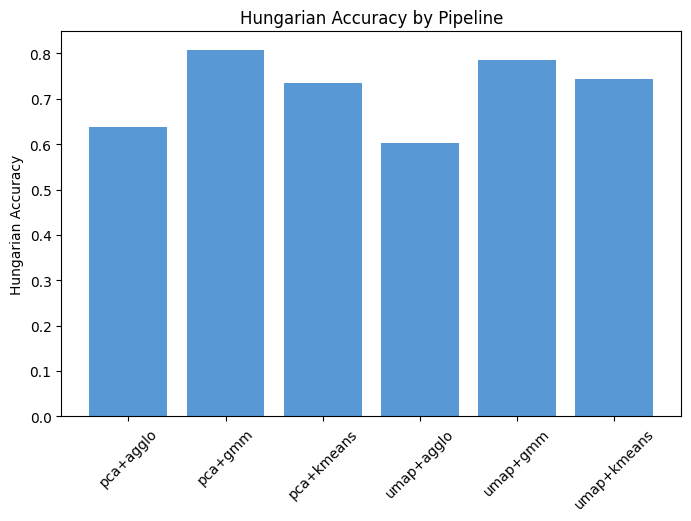

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(df_metrics["branch"], df_metrics["Hungarian"], color="#5898d4")
plt.title("Hungarian Accuracy by Pipeline")
plt.ylabel("Hungarian Accuracy")
plt.xticks(rotation=45)
plt.show()


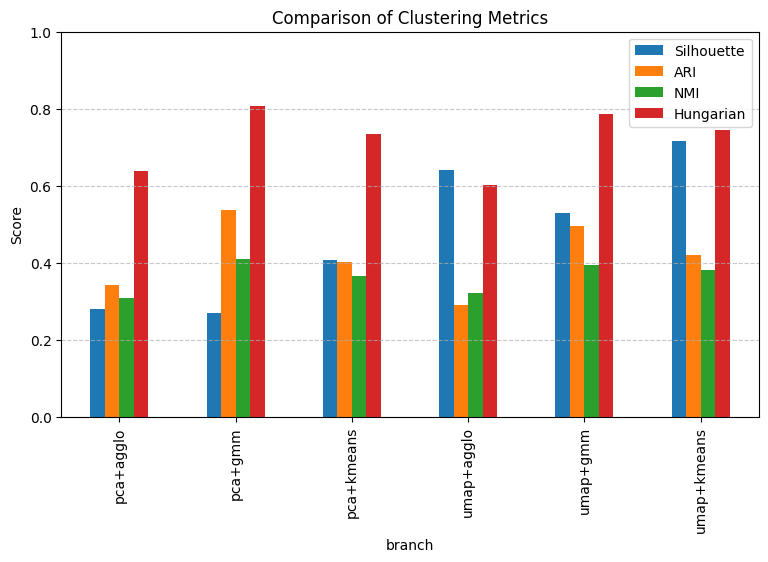

In [8]:
df_plot = df_metrics.set_index("branch")[["Silhouette","ARI","NMI","Hungarian"]]
df_plot.plot(kind="bar", figsize=(9,5))
plt.title("Comparison of Clustering Metrics")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


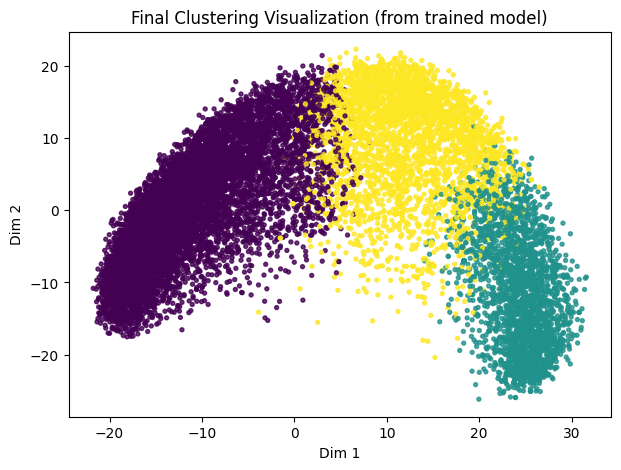

In [9]:
import matplotlib.pyplot as plt

X_vis = model.X_use_
labels = model.labels_

plt.figure(figsize=(7,5))
plt.scatter(X_vis[:,0], X_vis[:,1], c=labels, cmap='viridis', s=8, alpha=0.8)
plt.title("Final Clustering Visualization (from trained model)")
plt.xlabel("UMAP-1" if X_vis.shape[1]==2 else "Dim 1")
plt.ylabel("UMAP-2" if X_vis.shape[1]==2 else "Dim 2")
plt.show()
